# Imports and Paths

In [1]:
import pandas as pd
import numpy as np
from plotnine import *
import plotnine
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

plotnine.options.figure_size = (12, 8)
from pandas.api.types import is_string_dtype
pd.options.display.max_columns=100
pd.options.display.max_rows=100

In [2]:
from fastai.imports import *
from fastai.structured import *

In [3]:
PATH = '/data/msnow/football/'

# Random Forest Scraped Data All positions

## Load the Data

In [8]:
df_plyrs_raw = pd.read_feather(f'{PATH}df_plyr_past_and_future.feather')
print(list(df_plyrs_raw.columns))

['age', 'catch_pct', 'first_name', 'fumbles', 'games', 'games_started', 'last_name', 'player', 'player_id', 'pos', 'rec', 'rec_long', 'rec_per_g', 'rec_td', 'rec_yds', 'rec_yds_per_g', 'rec_yds_per_rec', 'targets', 'team', 'team_id', 'year', 'id', 'all_purpose_yds', 'all_purpose_yds_per_touch', 'rush_att', 'rush_att_per_g', 'rush_long', 'rush_receive_td', 'rush_td', 'rush_yds', 'rush_yds_per_att', 'rush_yds_per_g', 'touches', 'yds_from_scrimmage', 'fg_perc', 'fga', 'fga1', 'fga2', 'fga3', 'fga4', 'fga5', 'fgm', 'fgm1', 'fgm2', 'fgm3', 'fgm4', 'fgm5', 'punt', 'punt_blocked', 'punt_long', 'punt_yds', 'punt_yds_per_punt', 'xp_perc', 'xpa', 'xpm', 'comebacks', 'game_winning_drives', 'pass_adj_net_yds_per_att', 'pass_adj_yds_per_att', 'pass_att', 'pass_cmp', 'pass_cmp_perc', 'pass_int', 'pass_int_perc', 'pass_long', 'pass_net_yds_per_att', 'pass_rating', 'pass_sacked', 'pass_sacked_perc', 'pass_sacked_yds', 'pass_td', 'pass_td_perc', 'pass_yds', 'pass_yds_per_att', 'pass_yds_per_cmp', 'pass

In [45]:
df_plyrs = df_plyrs_raw.copy()
df_plyrs.drop(columns=['year','team','id','player','sea_left'], inplace=True)

In [63]:
df_plyrs_z[df_plyrs_z.columns[1]].dtype in ['float64', 'int64']

True

In [66]:
df_plyrs_z = df_plyrs.copy()
for i in df_plyrs_z.columns:
    if df_plyrs_z[i].dtype in ['float64', 'int64']:
        df_plyrs_z.loc[df_plyrs_z[i]<-500,i]=0
df_plyrs_z.fillna(0, inplace=True)

## Convert categorical columns to integers and split off target variable

In [46]:
df_plyrs = df_plyrs.loc[df_plyrs.player_id!='loveky00',:].reset_index(drop=True)

In [122]:
df_qb = df_plyrs_z.loc[(df_plyrs_z.pos=='rb') & (df_plyrs_z.ff_p1>0),:].reset_index(drop=True)
df_qb_cats = df_qb.copy()
train_cats(df_qb_cats)
df_x, df_y, nas = proc_df(df_qb_cats, 'ff_p1')
df_x.shape

(2331, 113)

In [121]:
df_plyrs_cat = df_plyrs.copy()
train_cats(df_plyrs_cat)
df_x, df_y, nas = proc_df(df_plyrs_cat, 'ff_p1')
df_x.shape

(62826, 113)

### Split the data into training and testing

In [123]:
id_trn_ct = int(0.8 * df_x.player_id.nunique())
id_trn = np.random.RandomState(42).choice(df_x.player_id.unique(),id_trn_ct, replace=False)

In [124]:
df_x_trn = df_x.loc[df_x.player_id.isin(id_trn),:]
df_y_trn = df_y[df_x_trn.index]
df_x_val = df_x.loc[~df_x.player_id.isin(id_trn),:]
df_y_val = df_y[df_x_val.index]

In [32]:
def custom_RFscore(m, train_set, valid_set, score_func='rmse', use_oob=False):
    train_pred = m.predict(train_set)
    if score_func == 'rmse':
        score = np.sqrt(((train_pred-valid_set)**2).mean())
    elif score_func == 'mse':
        score = ((train_pred - valid_set) ** 2).mean()
    if use_oob and hasattr(m, 'oob_score_'):
        return score, m.oob_score_
    return score

def print_custom_RFscore(df_x_trn, df_y_trn, df_x_val, df_y_val):
    train_rmse = custom_RFscore(m, df_x_trn, df_y_trn)
    valid_rmse = custom_RFscore(m, df_x_val, df_y_val) 
    train_score = m.score(df_x_trn, df_y_trn)
    valid_score = m.score(df_x_val, df_y_val)
    print(f'Training rmse: {train_rmse}')
    print(f'Validation rmse: {valid_rmse}')
    print(f'Training Score: {train_score}')
    print(f'Validation Score: {valid_score}')
    if hasattr(m, 'oob_score_'):
        print(f'OOB Score: {m.oob_score_}')

In [91]:
df_diag = pd.DataFrame({'x':[0,25], 'y':[0,25]})

In [125]:
df_y_trn.mean()

6.8067784637765616

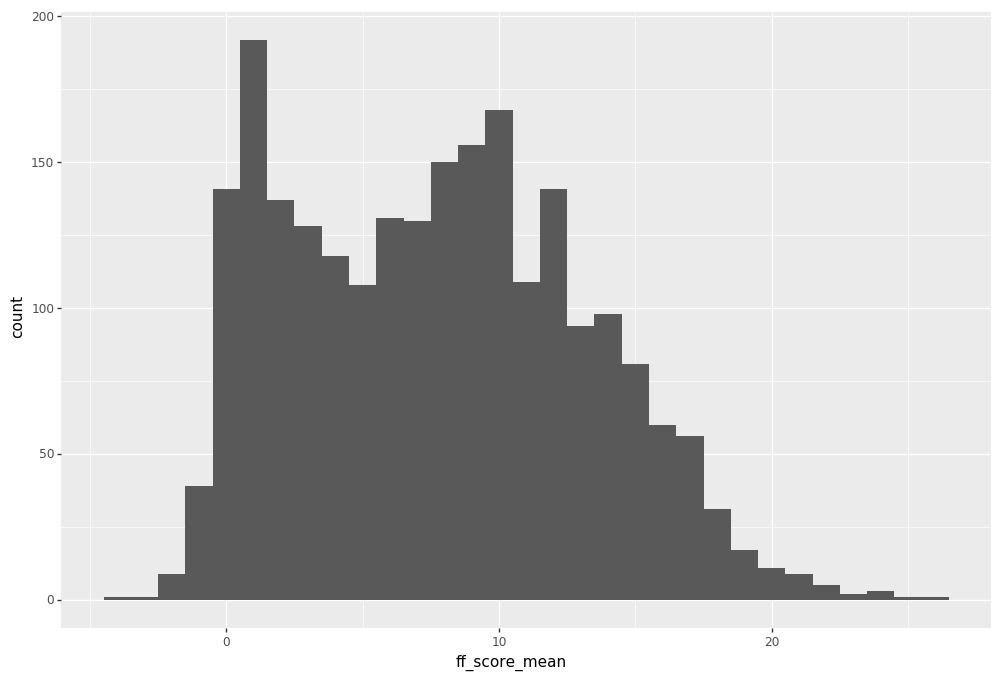

<ggplot: (8728815137705)>

In [76]:
ggplot(df_x_trn) + geom_histogram(aes(x='ff_score_mean'), binwidth=1)

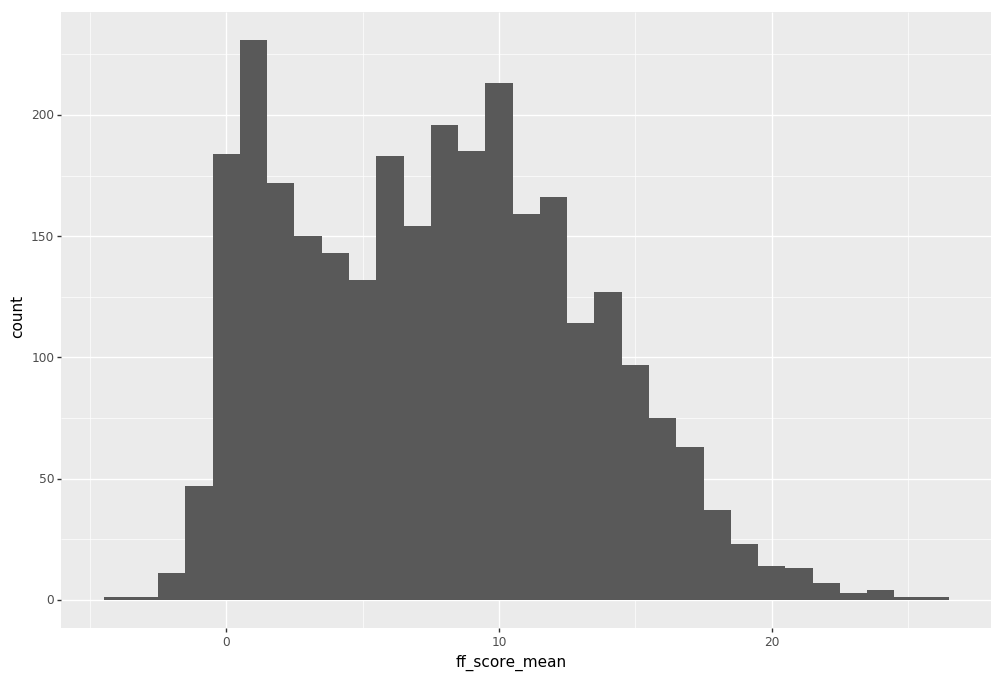

<ggplot: (-9223363308046283467)>

In [89]:
ggplot(df_x_val) + geom_histogram(aes(x='ff_score_mean'), binwidth=1)

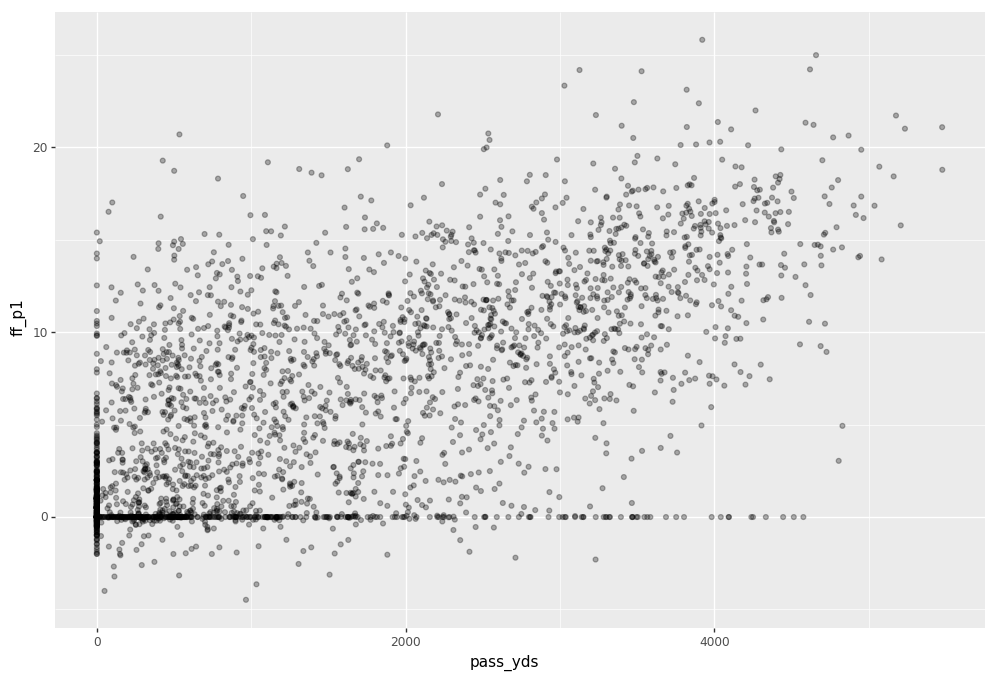

<ggplot: (8728806766898)>

In [109]:
columns = ['pass_yds','ff_p1']
ggplot(df_qb[columns]) + geom_point(aes(x=columns[0],y=columns[1]), alpha = 0.3) #+ geom_line(data = df_diag, mapping = aes(x='x',y='y'), color='red', size=2)

In [77]:
print(list(df_x_trn.columns))

['age', 'catch_pct', 'first_name', 'fumbles', 'games', 'games_started', 'last_name', 'player_id', 'pos', 'rec', 'rec_long', 'rec_per_g', 'rec_td', 'rec_yds', 'rec_yds_per_g', 'rec_yds_per_rec', 'targets', 'team_id', 'all_purpose_yds', 'all_purpose_yds_per_touch', 'rush_att', 'rush_att_per_g', 'rush_long', 'rush_receive_td', 'rush_td', 'rush_yds', 'rush_yds_per_att', 'rush_yds_per_g', 'touches', 'yds_from_scrimmage', 'fg_perc', 'fga', 'fga1', 'fga2', 'fga3', 'fga4', 'fga5', 'fgm', 'fgm1', 'fgm2', 'fgm3', 'fgm4', 'fgm5', 'punt', 'punt_blocked', 'punt_long', 'punt_yds', 'punt_yds_per_punt', 'xp_perc', 'xpa', 'xpm', 'comebacks', 'game_winning_drives', 'pass_adj_net_yds_per_att', 'pass_adj_yds_per_att', 'pass_att', 'pass_cmp', 'pass_cmp_perc', 'pass_int', 'pass_int_perc', 'pass_long', 'pass_net_yds_per_att', 'pass_rating', 'pass_sacked', 'pass_sacked_perc', 'pass_sacked_yds', 'pass_td', 'pass_td_perc', 'pass_yds', 'pass_yds_per_att', 'pass_yds_per_cmp', 'pass_yds_per_g', 'qb_rec', 'kick_ret

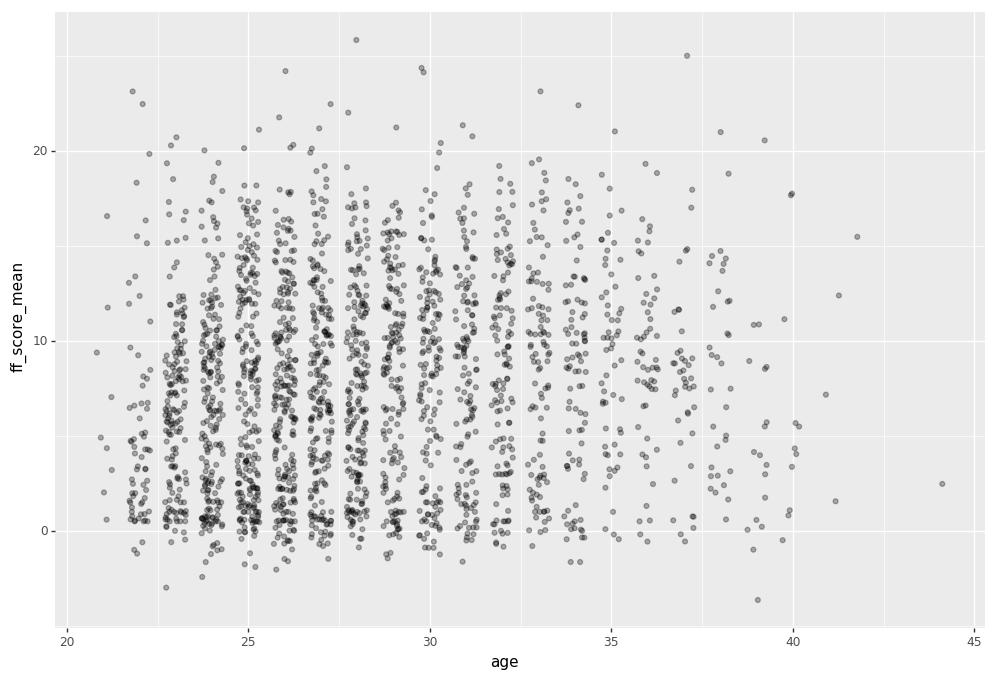

<ggplot: (-9223363308039889292)>

In [85]:
ggplot(df_x_trn) + geom_jitter(aes(x='age', y='ff_score_mean'), width=0.3, alpha=0.3)

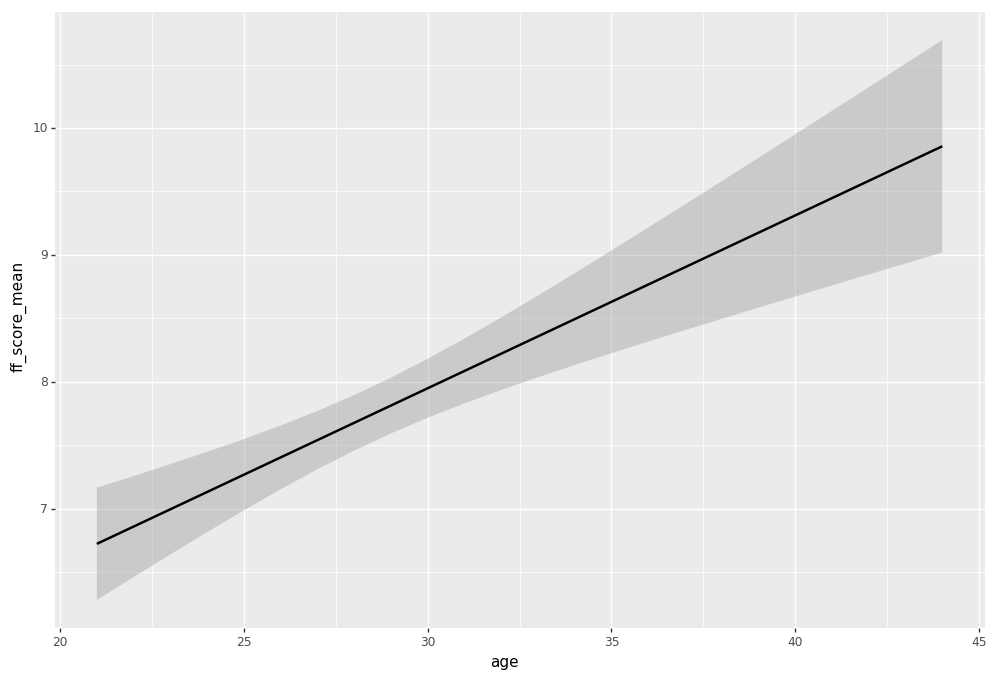

<ggplot: (-9223363308039759416)>

In [79]:
ggplot(df_x_trn) + geom_smooth(aes(x='age', y='ff_score_mean'))

## Run the Random Forest

In [126]:
m = RandomForestRegressor(n_estimators=30, max_features=0.5, n_jobs=-1, oob_score=True, random_state=42)
m.fit(df_x_trn, df_y_trn)
print_custom_RFscore(df_x_trn, df_y_trn, df_x_val, df_y_val)

Training rmse: 1.3827135404414301
Validation rmse: 3.7045911684772266
Training Score: 0.9196651283206329
Validation Score: 0.4712818920527451
OOB Score: 0.40428453079968085


In [117]:
m = RandomForestRegressor(n_estimators=60, max_features=0.5, n_jobs=-1, oob_score=True, random_state=42)
m.fit(df_x_trn, df_y_trn)
print_custom_RFscore(df_x_trn, df_y_trn, df_x_val, df_y_val)

Training rmse: 1.4608046195163933
Validation rmse: 3.5917594261686423
Training Score: 0.9277028302727557
Validation Score: 0.5692912232959861
OOB Score: 0.47194126528933633


## Feature importance

In [127]:
fi = rf_feat_importance(m, df_x_trn); fi[:10]

,cols,imp
27,rush_yds_per_g,0.190592
107,ff_score_mean,0.145524
106,ff_score,0.061435
29,yds_from_scrimmage,0.048508
21,rush_att_per_g,0.043192
109,ff_m1,0.031985
25,rush_yds,0.026615
18,all_purpose_yds,0.023003
28,touches,0.022811
0,age,0.022745


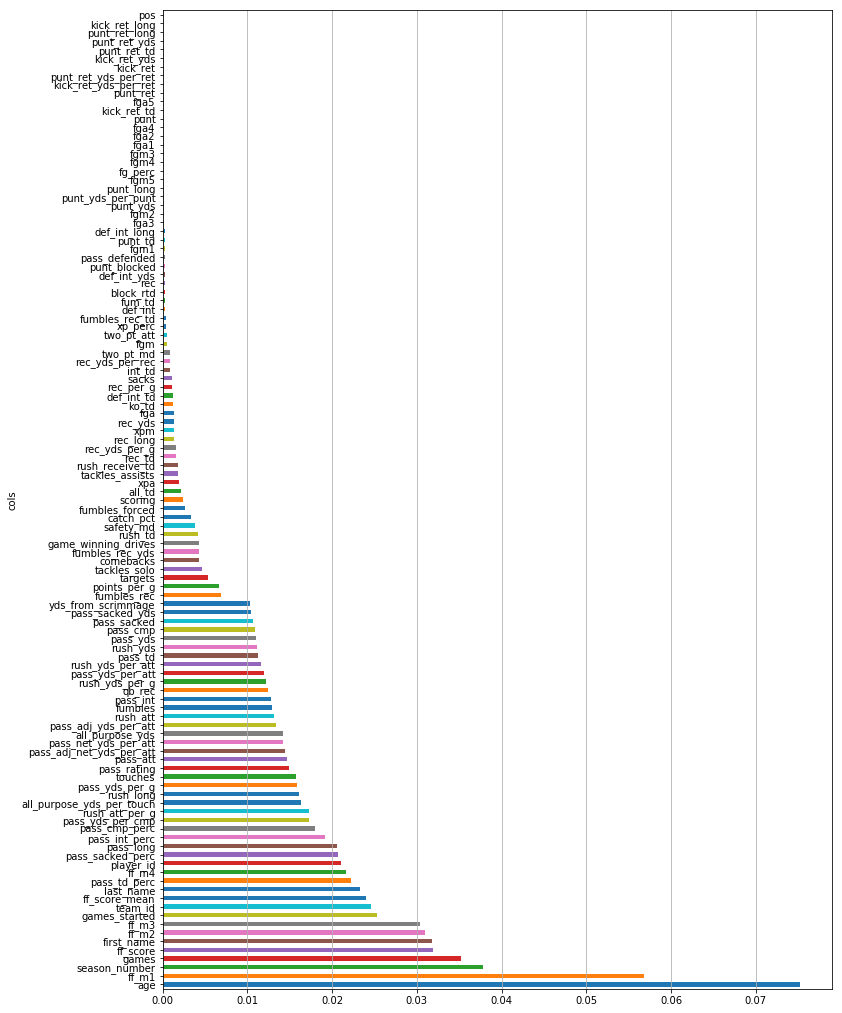

In [55]:
ax = fi.plot('cols', 'imp', 'barh', figsize=(12,18), legend=False, grid=True);
ax.yaxis.grid(False)

# Load and clean the data

In [4]:
df_games_raw = pd.read_feather(f'{PATH}df_games_raw.feather')
df_players_raw = pd.read_feather(f'{PATH}df_players_raw.feather')

In [10]:
df_games = df_games_raw.drop(columns=['age'])
df_players = df_players_raw.loc[:,['birth_date','height','player_id','position']]
df_players.birth_date = pd.to_datetime(df_players.birth_date, format='%Y-%m-%d')
df_players['birth_year'] = df_players.birth_date.dt.year

In [11]:
ht_tmp_ft = pd.to_numeric(df_players.height.str.split('-').str.get(0), errors='coerce') 
ht_tmp_in = pd.to_numeric(df_players.height.str.split('-').str.get(1), errors='coerce') 
ht_tmp = ht_tmp_ft*12 + ht_tmp_in
ht_tmp.fillna(ht_tmp.mean(),inplace=True)
ht_tmp = ht_tmp.astype(int)
df_players.height = ht_tmp

In [13]:
df_merge = df_games.merge(df_players, on='player_id', how='left')
df_merge['age'] = df_merge.year - df_merge.birth_year.astype(int)
df_merge.drop(columns=['birth_year'], inplace=True)

In [14]:
df_merge.head()

,date,defense_interception_touchdowns,defense_interception_yards,defense_interceptions,defense_sacks,defense_safeties,defense_tackle_assists,defense_tackles,field_goal_attempts,field_goal_makes,game_location,game_number,game_won,kick_return_attempts,kick_return_touchdowns,kick_return_yards,opponent,opponent_score,passing_attempts,passing_completions,passing_interceptions,passing_rating,passing_sacks,passing_sacks_yards_lost,passing_touchdowns,passing_yards,player_id,player_team_score,point_after_attemps,point_after_makes,punt_return_attempts,punt_return_touchdowns,punt_return_yards,punting_attempts,punting_blocked,punting_yards,receiving_receptions,receiving_targets,receiving_touchdowns,receiving_yards,rushing_attempts,rushing_touchdowns,rushing_yards,team,year,height,position,age
0,1990-09-09,0,0,0,0.0,0,0,0,0,0,A,1,False,0,0,0,CHI,17,0,0,0,0.0,0,0,0,0,1809,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,SEA,1990,72,DB,23
1,1990-09-16,0,0,0,0.0,0,0,0,0,0,H,2,False,0,0,0,RAI,17,0,0,0,0.0,0,0,0,0,1809,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,SEA,1990,72,DB,23
2,1990-09-23,0,0,0,0.0,0,0,0,0,0,A,3,False,0,0,0,DEN,34,0,0,0,0.0,0,0,0,0,1809,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,SEA,1990,72,DB,23
3,1990-10-01,0,0,0,0.0,0,0,0,0,0,H,4,True,0,0,0,CIN,16,0,0,0,0.0,0,0,0,0,1809,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,SEA,1990,72,DB,23
4,1990-10-07,0,0,0,0.0,0,0,0,0,0,A,5,True,0,0,0,NWE,20,0,0,0,0.0,0,0,0,0,1809,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,SEA,1990,72,DB,23


# Calculate the scores

In [16]:
ff_passing = df_merge.passing_yards*0.04 + df_merge.passing_touchdowns*4 - df_merge.passing_interceptions*2
ff_rushing = df_merge.rushing_yards*0.1 + df_merge.rushing_touchdowns*6
ff_receiving = df_merge.receiving_yards*0.1 + df_merge.receiving_touchdowns*6
ff_misc = df_merge.kick_return_touchdowns*6 + df_merge.punt_return_touchdowns*6 
ff_kick = df_merge.point_after_makes*2 - df_merge.point_after_attemps + df_merge.field_goal_makes * 5 - df_merge.field_goal_attempts
df_merge['ff_score'] = ff_passing + ff_rushing + ff_receiving + ff_misc + ff_kick

# Create the dataframe with the yearly average scores

In [28]:
df_year = df_merge.copy()
df_year.drop(columns=['date','game_location','opponent'], inplace=True)
df_year = df_year.groupby(['player_id', 'year'], sort=False, as_index=False).mean()
df_year = df_year.merge(df_players[['player_id','position']], on='player_id', how='left')

In [33]:
df_srt = df_year[['player_id', 'year']].sort_values(['player_id', 'year'])
first_season = df_srt[['player_id','year']].groupby(['player_id'], sort=False).first().reset_index()
first_season.rename(columns={'year':'first_season'}, inplace=True)
df_year = df_year.merge(first_season,on=['player_id'], how='left')
df_year['season_number'] = df_year.year - df_year.first_season
df_year.drop(columns=['first_season'], inplace=True)

In [34]:
df_year.head()

,player_id,year,defense_interception_touchdowns,defense_interception_yards,defense_interceptions,defense_sacks,defense_safeties,defense_tackle_assists,defense_tackles,field_goal_attempts,field_goal_makes,game_number,game_won,kick_return_attempts,kick_return_touchdowns,kick_return_yards,opponent_score,passing_attempts,passing_completions,passing_interceptions,passing_rating,passing_sacks,passing_sacks_yards_lost,passing_touchdowns,passing_yards,player_team_score,point_after_attemps,point_after_makes,punt_return_attempts,punt_return_touchdowns,punt_return_yards,punting_attempts,punting_blocked,punting_yards,receiving_receptions,receiving_targets,receiving_touchdowns,receiving_yards,rushing_attempts,rushing_touchdowns,rushing_yards,height,age,ff_score,position,season_number
0,1809,1990,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,8.6,0.533333,0.0,0.0,0.0,18.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.133333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,23.0,0.0,DB,0
1,1809,1991,0.0,3.6875,0.187500,0.062500,0.0,0.0,0.0,0.0,0.0,8.5,0.437500,0.0,0.0,0.0,16.312500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,24.0,0.0,DB,1
2,1809,1992,0.0,4.6000,0.066667,0.233333,0.0,0.0,0.0,0.0,0.0,8.8,0.133333,0.0,0.0,0.0,19.533333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,25.0,0.0,DB,2
3,1809,1993,0.0,0.0000,0.125000,0.000000,0.0,0.0,0.0,0.0,0.0,8.5,0.375000,0.0,0.0,0.0,19.625000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,26.0,0.0,DB,3
4,1809,1994,0.0,1.6000,0.066667,0.000000,0.0,0.0,0.0,0.0,0.0,8.0,0.400000,0.0,0.0,0.0,19.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.533333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,27.0,0.0,DB,4


In [71]:
df_year['ff_score_n1'] = -999
df_year['ff_score_n2'] = -999
df_year['ff_score_n3'] = -999
df_year.loc[df_year.index[df_year.season_number>0],'ff_score_n1'] = df_year.loc[(df_year.index[df_year.season_number>0] - 1),'ff_score'].values
df_year.loc[df_year.index[df_year.season_number>1],'ff_score_n2'] = df_year.loc[(df_year.index[df_year.season_number>1] - 2),'ff_score'].values
df_year.loc[df_year.index[df_year.season_number>2],'ff_score_n3'] = df_year.loc[(df_year.index[df_year.season_number>2] - 3),'ff_score'].values

In [268]:
# df_year.to_feather(f'{PATH}df_players_mn.feather')
df_year = pd.read_feather(f'{PATH}df_players_mn.feather')

In [269]:
df_yr_gb = df_year[['player_id','season_number']].groupby('player_id',sort=False,as_index=False).last()
df_yr_gb.rename(columns={'season_number':'total_seasons'}, inplace=True)
df_year = df_year.merge(df_yr_gb, on='player_id', how='left')

In [276]:
df_year['last_season'] = df_year.total_seasons - df_year.season_number
df_year.last_season = df_year.last_season+1
df_year.loc[df_year.last_season>1,'last_season'] = 0
df_year['future_score'] = -999
df_year.loc[df_year.last_season==0,'future_score'] = df_year.loc[(df_year.index[df_year.last_season==0] + 1),'ff_score'].values

In [287]:
df_year_predict = df_year.copy()
df_year_predict = df_year_predict.loc[df_year_predict.last_season == 0,:]
df_year_predict.reset_index(drop=True, inplace=True)
df_year_predict.drop(columns=['total_seasons','last_season'], inplace=True)
df_year_predict.head()

,player_id,year,defense_interception_touchdowns,defense_interception_yards,defense_interceptions,defense_sacks,defense_safeties,defense_tackle_assists,defense_tackles,field_goal_attempts,field_goal_makes,game_number,game_won,kick_return_attempts,kick_return_touchdowns,kick_return_yards,opponent_score,passing_attempts,passing_completions,passing_interceptions,passing_rating,passing_sacks,passing_sacks_yards_lost,passing_touchdowns,passing_yards,player_team_score,point_after_attemps,point_after_makes,punt_return_attempts,punt_return_touchdowns,punt_return_yards,punting_attempts,punting_blocked,punting_yards,receiving_receptions,receiving_targets,receiving_touchdowns,receiving_yards,rushing_attempts,rushing_touchdowns,rushing_yards,height,age,ff_score,position,season_number,ff_score_n1,ff_score_n2,ff_score_n3,future_score
0,1809,1990,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,8.6,0.533333,0.0,0.0,0.0,18.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.133333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,23.0,0.0,DB,0,-999.0,-999.0,-999.0,0.0
1,1809,1991,0.0,3.6875,0.187500,0.062500,0.0,0.0,0.0,0.0,0.0,8.5,0.437500,0.0,0.0,0.0,16.312500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,24.0,0.0,DB,1,0.0,-999.0,-999.0,0.0
2,1809,1992,0.0,4.6000,0.066667,0.233333,0.0,0.0,0.0,0.0,0.0,8.8,0.133333,0.0,0.0,0.0,19.533333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,25.0,0.0,DB,2,0.0,0.0,-999.0,0.0
3,1809,1993,0.0,0.0000,0.125000,0.000000,0.0,0.0,0.0,0.0,0.0,8.5,0.375000,0.0,0.0,0.0,19.625000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,26.0,0.0,DB,3,0.0,0.0,0.0,0.0
4,1809,1994,0.0,1.6000,0.066667,0.000000,0.0,0.0,0.0,0.0,0.0,8.0,0.400000,0.0,0.0,0.0,19.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.533333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,27.0,0.0,DB,4,0.0,0.0,0.0,0.0


# Random Forest

## Convert categorical columns to integers and split off target variable

In [288]:
df_year_cat = df_year_predict.copy()
train_cats(df_year_cat)
df_x, df_y, nas = proc_df(df_year_cat, 'future_score')

## Split the data into training and testing

In [100]:
def split_train_val(df, trn_amount, keep_order=True):
    if 0 <= trn_amount <= 1:
        n_trn = int(len(df)*trn_amount)
    else:
        n_trn = trn_amount
    if not keep_order:
        df = df.sample(frac=1)
    df_train = df[:n_trn]
    df_valid = df[n_trn:]
    return [df_train, df_valid]

In [289]:
len(df_x), df_x.player_id.nunique()

(67181, 14072)

In [290]:
id_trn_ct = int(0.8 * df_x.player_id.nunique())
id_trn = np.random.RandomState(42).choice(df_x.player_id.unique(),id_trn_ct, replace=False)

In [291]:
df_year_cat.loc[df_year_cat.future_score>0,:].head(10)

,player_id,year,defense_interception_touchdowns,defense_interception_yards,defense_interceptions,defense_sacks,defense_safeties,defense_tackle_assists,defense_tackles,field_goal_attempts,field_goal_makes,game_number,game_won,kick_return_attempts,kick_return_touchdowns,kick_return_yards,opponent_score,passing_attempts,passing_completions,passing_interceptions,passing_rating,passing_sacks,passing_sacks_yards_lost,passing_touchdowns,passing_yards,player_team_score,point_after_attemps,point_after_makes,punt_return_attempts,punt_return_touchdowns,punt_return_yards,punting_attempts,punting_blocked,punting_yards,receiving_receptions,receiving_targets,receiving_touchdowns,receiving_yards,rushing_attempts,rushing_touchdowns,rushing_yards,height,age,ff_score,position,season_number,ff_score_n1,ff_score_n2,ff_score_n3,future_score
19,18182,1970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.000000,0.000000,0.000000,0.0,0.000000,24.000000,0.000000,2.000000,0.000000,39.600000,0.0,0.0,0.000000,0.000000,3.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,74.0,22.0,0.000000,QB,0,-999.000000,-999.000000,-999.000000,4.377778
20,18182,1971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.000000,0.333333,0.000000,0.0,0.000000,21.333333,9.333333,19.777778,1.444444,51.333333,0.0,0.0,0.555556,124.444444,14.888889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.666667,74.0,23.0,4.377778,QB,1,0.000000,-999.000000,-999.000000,5.500000
21,18182,1972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.777778,0.333333,0.000000,0.0,0.000000,25.444444,7.222222,15.222222,1.000000,57.033333,0.0,0.0,0.333333,116.666667,24.222222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.666667,0.222222,1.666667,74.0,24.0,5.500000,QB,2,4.377778,0.000000,-999.000000,2.352000
22,18182,1973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.200000,0.600000,0.000000,0.0,0.000000,23.800000,2.000000,5.400000,0.400000,68.780000,0.0,0.0,0.400000,38.800000,31.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,74.0,25.0,2.352000,QB,3,5.500000,4.377778,0.000000,4.142857
23,18182,1974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.714286,0.428571,0.000000,0.0,0.000000,22.571429,5.857143,10.571429,1.000000,49.942857,0.0,0.0,0.714286,82.857143,17.857143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.714286,0.000000,-0.285714,74.0,26.0,4.142857,QB,4,2.352000,5.500000,4.377778,6.752727
24,18182,1975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.818182,0.454545,0.000000,0.0,0.000000,19.636364,11.636364,21.181818,1.272727,65.609091,0.0,0.0,0.818182,142.000000,17.636364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.545455,0.000000,3.454545,74.0,27.0,6.752727,QB,5,4.142857,2.352000,5.500000,8.361667
28,11755,2001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.000000,0.588235,0.235294,0.0,4.588235,19.588235,0.000000,0.058824,0.000000,2.329412,0.0,0.0,0.000000,0.000000,19.529412,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.411765,0.588235,0.058824,2.588235,2.588235,0.058824,19.000000,70.0,23.0,2.864706,RB,0,-999.000000,-999.000000,-999.000000,5.562500
29,11755,2002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.000000,0.562500,0.500000,0.0,9.562500,20.812500,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,23.625000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.125000,1.500000,0.000000,10.562500,6.625000,0.312500,26.312500,70.0,24.0,5.562500,RB,1,2.864706,-999.000000,-999.000000,3.318750
30,11755,2003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.500000,0.375000,0.687500,0.0,13.062500,18.687500,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,17.687500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.687500,0.812500,0.000000,6.312500,2.875000,0.250000,11.875000,70.0,25.0,3.318750,RB,2,5.562500,2.864706,-999.000000,4.416667
31,11755,2004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.500000,0.611111,0.777778,0.0,15.777778,16.555556,0.000000,0.055556,0.055556,0.000000,0.0,0.0,0.000000,0.000000,2

In [292]:
df_x_trn = df_x.loc[df_x.player_id.isin(id_trn),:]
df_y_trn = df_y[df_x_trn.index]
df_x_val = df_x.loc[~df_x.player_id.isin(id_trn),:]
df_y_val = df_y[df_x_val.index]

In [148]:
def custom_RFscore(m, train_set, valid_set, score_func='rmse', use_oob=False):
    train_pred = m.predict(train_set)
    if score_func == 'rmse':
        score = np.sqrt(((train_pred-valid_set)**2).mean())
    elif score_func == 'mse':
        score = ((train_pred - valid_set) ** 2).mean()
    if use_oob and hasattr(m, 'oob_score_'):
        return score, m.oob_score_
    return score

def print_custom_RFscore(df_x_trn, df_y_trn, df_x_val, df_y_val):
    train_rmse = custom_RFscore(m, df_x_trn, df_y_trn)
    valid_rmse = custom_RFscore(m, df_x_val, df_y_val) 
    train_score = m.score(df_x_trn, df_y_trn)
    valid_score = m.score(df_x_val, df_y_val)
    print(f'Training rmse: {train_rmse}')
    print(f'Validation rmse: {valid_rmse}')
    print(f'Training Score: {train_score}')
    print(f'Validation Score: {valid_score}')
    if hasattr(m, 'oob_score_'):
        print(f'OOB Score: {m.oob_score_}')

In [296]:
m = RandomForestRegressor(n_estimators=30, max_features=0.5, n_jobs=-1, oob_score=True, random_state=42)
m.fit(df_x_trn, df_y_trn)
print_custom_RFscore(df_x_trn, df_y_trn, df_x_val, df_y_val)

Training rmse: 0.7099726216411326
Validation rmse: 1.7768387248511543
Training Score: 0.9606174179515635
Validation Score: 0.7383117486658963
OOB Score: 0.7208357583395242


In [149]:
m = RandomForestRegressor(n_estimators=30, max_features=0.5, n_jobs=-1, oob_score=True, random_state=42)
m.fit(df_x_trn, df_y_trn)
print_custom_RFscore(df_x_trn, df_y_trn, df_x_val, df_y_val)

Training rmse: 0.11262057182103008
Validation rmse: 0.27449739090051034
Training Score: 0.9988637934946156
Validation Score: 0.993685039521444
OOB Score: 0.9916882216570798


## Feature Importance

In [297]:
fi = rf_feat_importance(m, df_x_trn); fi[:10]

,cols,imp
43,ff_score,0.454058
46,ff_score_n1,0.147088
38,rushing_attempts,0.055501
47,ff_score_n2,0.045041
40,rushing_yards,0.026291
37,receiving_yards,0.023428
34,receiving_receptions,0.022521
24,passing_yards,0.018842
11,game_number,0.016078
16,opponent_score,0.016058


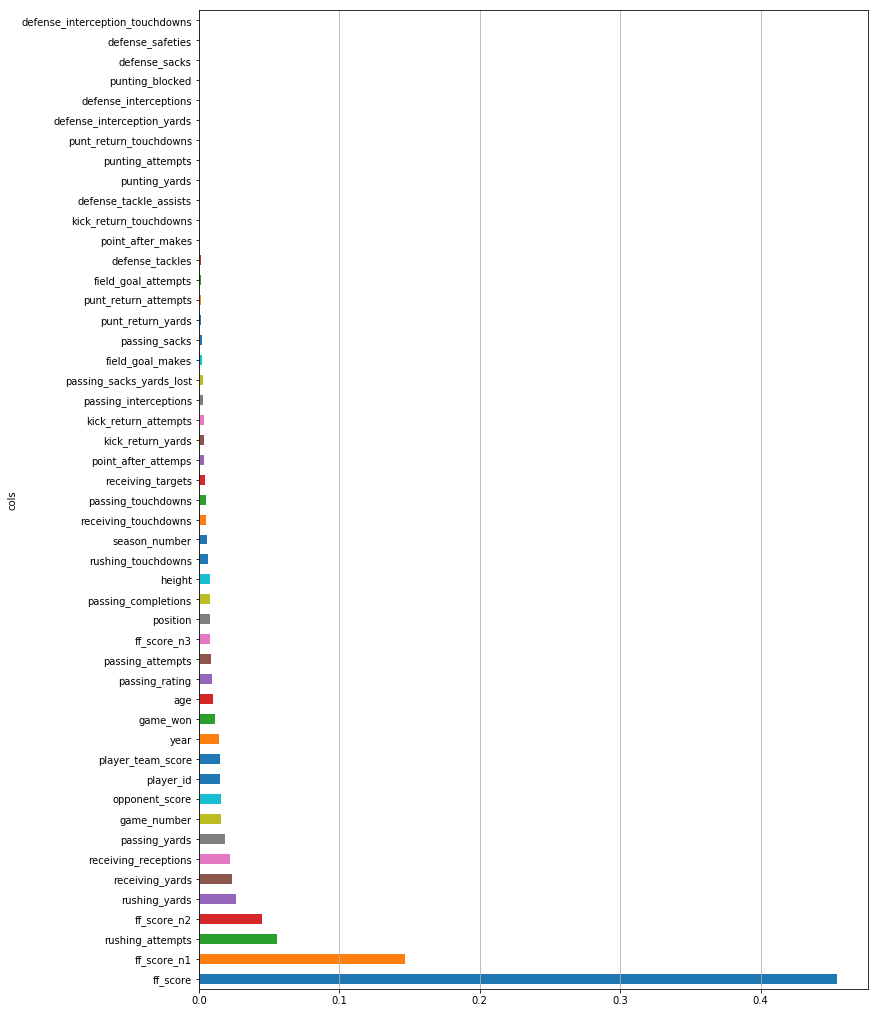

In [298]:
ax = fi.plot('cols', 'imp', 'barh', figsize=(12,18), legend=False, grid=True);
ax.yaxis.grid(False)

In [299]:
top_ft = fi[fi.imp>0.005].cols;
df_x_trn_top_ft = df_x_trn[top_ft]
df_x_val_top_ft = df_x_val[top_ft]

In [300]:
m = RandomForestRegressor(n_estimators=30, max_features=0.5, n_jobs=-1, oob_score=True, random_state=42)
m.fit(df_x_trn_top_ft, df_y_trn)
print_custom_RFscore(df_x_trn_top_ft, df_y_trn, df_x_val_top_ft, df_y_val)

Training rmse: 0.7078152300944788
Validation rmse: 1.779981777198134
Training Score: 0.9608563977590237
Validation Score: 0.7373851284593804
OOB Score: 0.7222948633221922


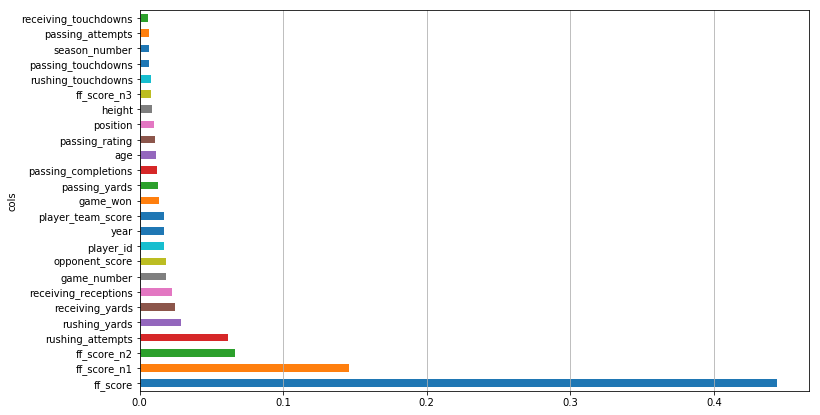

In [301]:
fi = rf_feat_importance(m, df_x_trn_top_ft)
ax = fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False, grid=True);
ax.yaxis.grid(False)

## Predictions

In [164]:
df_x_tst = df_year.copy()
df_x_tst = df_x_tst.loc[df_x_tst.year==2017,:]
df_x_tst.ff_score_n3 = df_x_tst.ff_score_n2
df_x_tst.ff_score_n2 = df_x_tst.ff_score_n1
df_x_tst.ff_score_n1 = df_x_tst.ff_score
top_ft_pos = list(top_ft) + ['position']
df_x_tst = df_x_tst[top_ft_pos]

In [165]:
df_x_tst.head()

,ff_score_n1,receiving_yards,ff_score_n2,rushing_yards,receiving_receptions,passing_yards,passing_touchdowns,rushing_attempts,rushing_touchdowns,receiving_touchdowns,field_goal_makes,passing_attempts,field_goal_attempts,point_after_attemps,passing_rating,point_after_makes,position
21,0.000000,0.000000,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,ILB
34,0.000000,0.000000,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,ILB
60,0.000000,0.000000,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,DE
150,6.444444,51.111111,8.3500,0.0,4.111111,0.0,0.0,0.0,0.0,0.222222,0.0,0.0,0.0,0.0,0.0,0.0,WR
211,7.320000,15.800000,8.8125,45.4,2.000000,0.0,0.0,10.2,0.2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,RB


In [187]:
df_x_tst_qb = df_x_tst.loc[df_x_tst.position=='QB',:].copy()
df_x_tst_qb.drop(columns='position',inplace=True)
predict_ff = m.predict(df_x_tst_qb)
df_predict_qb = pd.DataFrame({'player_id':df_year.loc[df_x_tst_qb.index,'player_id'].values,'prediction':predict_ff})
df_predict_qb = df_predict_qb.merge(df_players_raw[['player_id','name']], on='player_id', how='left')
df_predict_qb.sort_values('prediction', ascending=False).reset_index()

,index,player_id,prediction,name
0,22,2240,21.647070,Tom Brady
1,24,23623,21.555527,Carson Wentz
2,47,23402,21.030861,Deshaun Watson
3,6,24421,20.426173,Russell Wilson
4,34,20509,19.570091,Alex Smith
5,49,4644,19.404533,Kirk Cousins
6,4,7476,18.978961,Blaine Gabbert
7,60,16363,18.691096,Cam Newton
8,21,21069,17.907130,Matthew Stafford
9,53,2328,16.987841,Drew Brees


In [189]:
df_players_raw.columns

Index(['birth_date', 'birth_place', 'college', 'current_salary',
       'current_team', 'death_date', 'draft_position', 'draft_round',
       'draft_team', 'draft_year', 'height', 'high_school',
       'hof_induction_year', 'name', 'player_id', 'position', 'weight'],
      dtype='object')

In [314]:
# df_predict = df_year.copy()
# train_cats(df_predict)
# df_predict = df_predict.loc[df_predict.year==2017,:]
# df_predict_x, df_y, nas = proc_df(df_predict, 'future_score')
# df_predict_x = df_predict_x[top_ft]
# predict_ff = m.predict(df_predict_x)
df_predict_all = pd.DataFrame({'player_id':df_year.loc[df_predict_x.index,'player_id'].values,'prediction':predict_ff})
df_predict_all = df_predict_all.merge(df_players_raw[['player_id','name','position']], on='player_id', how='left')
df_predict_all = df_predict_all.sort_values('prediction', ascending=False).reset_index(drop=True)
df_predict_all

,player_id,prediction,name,position
0,2240,19.853978,Tom Brady,QB
1,2328,19.325577,Drew Brees,QB
2,24421,18.309052,Russell Wilson,QB
3,16363,17.440978,Cam Newton,QB
4,18745,16.822784,Philip Rivers,QB
5,21069,16.762723,Matthew Stafford,QB
6,4644,16.719944,Kirk Cousins,QB
7,18977,16.438696,Ben Roethlisberger,QB
8,19319,15.918555,Matt Ryan,QB
9,8015,15.871279,Jared Goff,QB


In [193]:
df_x_tst = df_year.copy()
df_x_tst = df_x_tst.loc[df_x_tst.year==2017,:]
df_x_tst.ff_score_n3 = df_x_tst.ff_score_n2
df_x_tst.ff_score_n2 = df_x_tst.ff_score_n1
df_x_tst.ff_score_n1 = df_x_tst.ff_score
df_x_tst = df_x_tst[top_ft]
df_x_tst_all = df_x_tst.copy()
df_x_tst_all.drop(columns='position',inplace=True)
predict_ff = m.predict(df_x_tst_all)
df_predict_all = pd.DataFrame({'player_id':df_year.loc[df_x_tst_all.index,'player_id'].values,'prediction':predict_ff})
df_predict_all = df_predict_all.merge(df_players_raw[['player_id','name','position']], on='player_id', how='left')
df_predict_all = df_predict_all.sort_values('prediction', ascending=False).reset_index(drop=True)
df_predict_all

,player_id,prediction,name,position
0,2240,21.647070,Tom Brady,QB
1,23623,21.555527,Carson Wentz,QB
2,23402,21.030861,Deshaun Watson,QB
3,24421,20.426173,Russell Wilson,QB
4,20509,19.570091,Alex Smith,QB
5,4644,19.404533,Kirk Cousins,QB
6,6375,19.260575,Ezekiel Elliott,RB
7,7476,18.978961,Blaine Gabbert,QB
8,16363,18.691096,Cam Newton,QB
9,21069,17.907130,Matthew Stafford,QB


In [315]:
df_predict_all.loc[df_predict_all.position=='QB',:].reset_index()

,index,player_id,prediction,name,position
0,0,2240,19.853978,Tom Brady,QB
1,1,2328,19.325577,Drew Brees,QB
2,2,24421,18.309052,Russell Wilson,QB
3,3,16363,17.440978,Cam Newton,QB
4,4,18745,16.822784,Philip Rivers,QB
5,5,21069,16.762723,Matthew Stafford,QB
6,6,4644,16.719944,Kirk Cousins,QB
7,7,18977,16.438696,Ben Roethlisberger,QB
8,8,19319,15.918555,Matt Ryan,QB
9,9,8015,15.871279,Jared Goff,QB


In [316]:
df_predict_all.loc[df_predict_all.position=='RB',:].reset_index()

,index,player_id,prediction,name,position
0,15,1465,15.235942,Le'Veon Bell,RB
1,19,8657,13.766135,Todd Gurley,RB
2,20,6375,13.604094,Ezekiel Elliott,RB
3,25,11877,12.572053,Alvin Kamara,RB
4,26,7203,12.504646,Leonard Fournette,RB
5,27,10496,12.443660,Kareem Hunt,RB
6,29,10635,12.262021,Mark Ingram,RB
7,36,4458,11.000477,Dalvin Cook,RB
8,39,11230,10.825587,David Johnson,RB
9,41,8145,10.658370,Melvin Gordon,RB


In [317]:
df_predict_all.loc[df_predict_all.position=='WR',:].reset_index()

,index,player_id,prediction,name,position
0,31,10191,11.912932,DeAndre Hopkins,WR
1,37,11634,10.949504,Julio Jones,WR
2,44,2544,10.447373,Antonio Brown,WR
3,49,21992,9.904680,Adam Thielen,WR
4,50,4480,9.815115,Brandin Cooks,WR
5,56,8337,9.602624,A.J. Green,WR
6,63,484,9.094116,Robby Anderson,WR
7,65,317,8.964174,Keenan Allen,WR
8,67,9894,8.865922,Tyreek Hill,WR
9,70,22095,8.744008,Michael Thomas,WR


In [318]:
df_predict_all.loc[df_predict_all.position=='TE',:].reset_index()

,index,player_id,prediction,name,position
0,51,8573,9.800288,Rob Gronkowski,TE
1,81,6520,8.185353,Zach Ertz,TE
2,87,12018,8.035420,Travis Kelce,TE
3,136,6484,6.749833,Evan Engram,TE
4,149,23085,6.453121,Delanie Walker,TE
5,159,9655,6.239659,Hunter Henry,TE
6,171,8220,5.995345,Jimmy Graham,TE
7,172,18350,5.974083,Jordan Reed,TE
8,187,10180,5.709470,Austin Hooper,TE
9,190,16456,5.608752,David Njoku,TE


In [319]:
df_predict_all.loc[df_predict_all.position=='K',:].reset_index()

,index,player_id,prediction,name,position
0,52,6376,9.724219e+00,Jake Elliott,K
1,53,2069,9.669507e+00,Chris Boswell,K
2,54,25034,9.604209e+00,Greg Zuerlein,K
3,55,3132,9.603178e+00,Harrison Butker,K
4,60,8172,9.264237e+00,Stephen Gostkowski,K
5,75,21508,8.585248e+00,Caleb Sturgis,K
6,76,12803,8.553914e+00,Josh Lambo,K
7,77,16578,8.511425e+00,Mike Nugent,K
8,80,7114,8.275622e+00,Kai Forbath,K
9,82,2858,8.138957e+00,Matt Bryant,K


In [321]:
df_predict_all.loc[~df_predict_all.position.isin(['K','TE','WR','RB','QB' ]),:].reset_index()

,index,player_id,prediction,name,position
0,59,7575,9.276793,Graham Gano,P
1,113,15617,7.179469,Ty Montgomery,WR/RB
2,393,9641,2.985139,Thomas Hennessy,LS
3,403,18307,2.876657,Kasey Redfern,P
4,433,561,2.447849,Alex Anzalone,OLB
5,435,2131,2.414654,Tyus Bowser,OLB
6,437,5020,2.410058,Joe Dahl,OG
7,442,2204,2.376250,Bam Bradley,OLB
8,448,10038,2.301707,Colin Holba,LS
9,449,14647,2.288636,Conor McDermott,OT


# Teams

## Clean the Data

In [324]:
df_teams_avg_raw = pd.read_feather(f'{PATH}df_teams_avg.feather')

In [328]:
df_tm_gb = df_teams_avg_raw[['team','Year']].groupby('team',as_index=False).last()
df_tm_gb.rename(columns={'Year':'last_year'}, inplace=True)
df_teams_avg = df_teams_avg_raw.merge(df_tm_gb, on='team', how='left')

In [330]:
df_teams_avg['last_season'] = df_teams_avg.last_year - df_teams_avg.Year
df_teams_avg.last_season = df_teams_avg.last_season+1
df_teams_avg.loc[df_teams_avg.last_season>1,'last_season'] = 0
df_teams_avg['future_score'] = -999
df_teams_avg.loc[df_teams_avg.last_season==0,'future_score'] = df_teams_avg.loc[(df_teams_avg.index[df_teams_avg.last_season==0] + 1),'ff_score'].values

In [332]:
df_teams_predict = df_teams_avg.copy()
df_teams_predict = df_teams_predict.loc[df_teams_predict.last_season == 0,:]
df_teams_predict.reset_index(drop=True, inplace=True)
df_teams_predict.drop(columns=['last_year','last_season'], inplace=True)
df_teams_predict.head()

,team,Year,blocked_fg_td,def_int,first_down_def,first_down_off,fumbles_rec,fumbles_rec_td,int_td,kick_ret_td,pass_yds_def,pass_yds_off,pts_def,pts_off,punt_blocked,punt_ret_td,rush_yds_def,rush_yds_off,sacks,safety_md,to_def,to_off,yards_def,yards_off,pa_00,pa_01_06,pa_07_13,pa_14_21,pa_28_34,pa_inf,ff_score,season_number,ff_n1,ff_n2,ff_n3,ff_n4,future_score
0,Arizona Cardinals,1994,0.0000,1.4375,15.3125,17.9375,1.6875,0.0000,0.0625,0.0,189.8750,190.4375,16.6875,14.6875,0.0,0.0,85.6250,97.5000,2.1875,0.0625,2.2500,1.8125,275.5000,287.9375,0.0,0.0625,0.3125,0.4375,0.1250,0.0625,10.6875,0,-999.0000,-999.0000,-999.0000,-999.0000,11.3125
1,Arizona Cardinals,1995,0.0625,1.1875,19.3750,17.8125,2.6250,0.0625,0.2500,0.0,215.9375,218.9375,26.3750,17.1875,0.0,0.0,140.5625,85.1875,1.9375,0.0000,2.6250,2.6875,356.5000,304.1250,0.0,0.0000,0.0625,0.2500,0.2500,0.1875,11.3125,1,10.6875,-999.0000,-999.0000,-999.0000,6.8750
2,Arizona Cardinals,1996,0.0000,0.6875,21.0625,19.2500,1.5625,0.0625,0.0625,0.0,218.6875,230.5000,24.8125,18.7500,0.0,0.0,116.3750,93.8750,1.7500,0.0000,1.5625,2.1875,335.0625,324.3750,0.0,0.0000,0.1250,0.2500,0.3750,0.1250,6.8750,2,11.3125,10.6875,-999.0000,-999.0000,7.3125
3,Arizona Cardinals,1997,0.0625,0.9375,18.6250,18.4375,0.7500,0.0000,0.1875,0.0,202.8750,216.1250,23.6875,17.6875,0.0,0.0,136.2500,78.4375,2.1250,0.0000,1.2500,2.6250,339.1250,294.5625,0.0,0.0000,0.1250,0.3125,0.0000,0.1250,7.3125,3,6.8750,11.3125,10.6875,-999.0000,9.5625
4,Arizona Cardinals,1998,0.0000,1.2500,20.0625,19.6875,2.0000,0.0000,0.0625,0.0,204.7500,217.6250,23.6250,20.3125,0.0,0.0,124.3125,101.6875,2.4375,0.0000,2.4375,2.2500,329.0625,319.3125,0.0,0.0625,0.1250,0.2500,0.1875,0.1875,9.5625,4,7.3125,6.8750,11.3125,10.6875,9.0625


In [335]:
df_teams_predict.shape

(1435, 37)

In [336]:
df_teams_predict.dtypes

team               object
Year                int64
blocked_fg_td     float64
def_int           float64
first_down_def    float64
first_down_off    float64
fumbles_rec       float64
fumbles_rec_td    float64
int_td            float64
kick_ret_td       float64
pass_yds_def      float64
pass_yds_off      float64
pts_def           float64
pts_off           float64
punt_blocked      float64
punt_ret_td       float64
rush_yds_def      float64
rush_yds_off      float64
sacks             float64
safety_md         float64
to_def            float64
to_off            float64
yards_def         float64
yards_off         float64
pa_00             float64
pa_01_06          float64
pa_07_13          float64
pa_14_21          float64
pa_28_34          float64
pa_inf            float64
ff_score          float64
season_number       int64
ff_n1             float64
ff_n2             float64
ff_n3             float64
ff_n4             float64
future_score      float64
dtype: object

## Random Forest

### Convert categorical columns to integers and split off target variable

In [352]:
df_teams = df_teams_predict.copy()
df_teams.drop(columns='Year', inplace=True)
train_cats(df_teams)
df_x, df_y, nas = proc_df(df_teams, 'future_score')
df_x.shape

(1435, 35)

### Split the data into training and testing

In [353]:
len(df_x), df_x.team.nunique()

(1435, 39)

In [354]:
id_trn_ct = int(0.8 * df_x.team.nunique())
id_trn = np.random.RandomState(42).choice(df_x.team.unique(),id_trn_ct, replace=False)

In [355]:
df_x_trn = df_x.loc[df_x.team.isin(id_trn),:]
df_y_trn = df_y[df_x_trn.index]
df_x_val = df_x.loc[~df_x.team.isin(id_trn),:]
df_y_val = df_y[df_x_val.index]

In [223]:
def custom_RFscore(m, train_set, valid_set, score_func='rmse', use_oob=False):
    train_pred = m.predict(train_set)
    if score_func == 'rmse':
        score = np.sqrt(((train_pred-valid_set)**2).mean())
    elif score_func == 'mse':
        score = ((train_pred - valid_set) ** 2).mean()
    if use_oob and hasattr(m, 'oob_score_'):
        return score, m.oob_score_
    return score

def print_custom_RFscore(df_x_trn, df_y_trn, df_x_val, df_y_val):
    train_rmse = custom_RFscore(m, df_x_trn, df_y_trn)
    valid_rmse = custom_RFscore(m, df_x_val, df_y_val) 
    train_score = m.score(df_x_trn, df_y_trn)
    valid_score = m.score(df_x_val, df_y_val)
    print(f'Training rmse: {train_rmse}')
    print(f'Validation rmse: {valid_rmse}')
    print(f'Training Score: {train_score}')
    print(f'Validation Score: {valid_score}')
    if hasattr(m, 'oob_score_'):
        print(f'OOB Score: {m.oob_score_}')

In [356]:
df_y_trn.mean()

10.340647183050617

### Run the random forest

In [364]:
m = RandomForestRegressor(n_estimators=30, max_features=0.5, n_jobs=-1, oob_score=True, random_state=42)
m.fit(df_x_trn, df_y_trn)
print_custom_RFscore(df_x_trn, df_y_trn, df_x_val, df_y_val)

Training rmse: 0.8912173212050214
Validation rmse: 2.246632266630268
Training Score: 0.8803093079133184
Validation Score: 0.20308558041508248
OOB Score: 0.18128978136018437


In [230]:
m = RandomForestRegressor(n_estimators=60, max_features=0.5, n_jobs=-1, oob_score=True, random_state=42)
m.fit(df_x_trn, df_y_trn)
print_custom_RFscore(df_x_trn, df_y_trn, df_x_val, df_y_val)

Training rmse: 0.3236691111848375
Validation rmse: 0.9019312573447138
Training Score: 0.983634180195735
Validation Score: 0.8859804515489946
OOB Score: 0.8833998908199194


### Feature Importance

In [365]:
fi = rf_feat_importance(m, df_x_trn); fi[:10]

,cols,imp
29,ff_score,0.110360
31,ff_n1,0.074584
21,yards_def,0.064172
19,to_def,0.063128
30,season_number,0.053593
11,pts_def,0.045069
9,pass_yds_def,0.041734
3,first_down_def,0.037976
16,rush_yds_off,0.033565
20,to_off,0.032847


In [231]:
fi = rf_feat_importance(m, df_x_trn); fi[:10]

,cols,imp
20,to_def,0.322736
12,pts_def,0.248707
3,def_int,0.104947
18,sacks,0.076776
22,yards_def,0.057740
6,fumbles_rec,0.036590
8,int_td,0.022176
4,first_down_def,0.014909
29,pa_inf,0.010959
7,fumbles_rec_td,0.008620


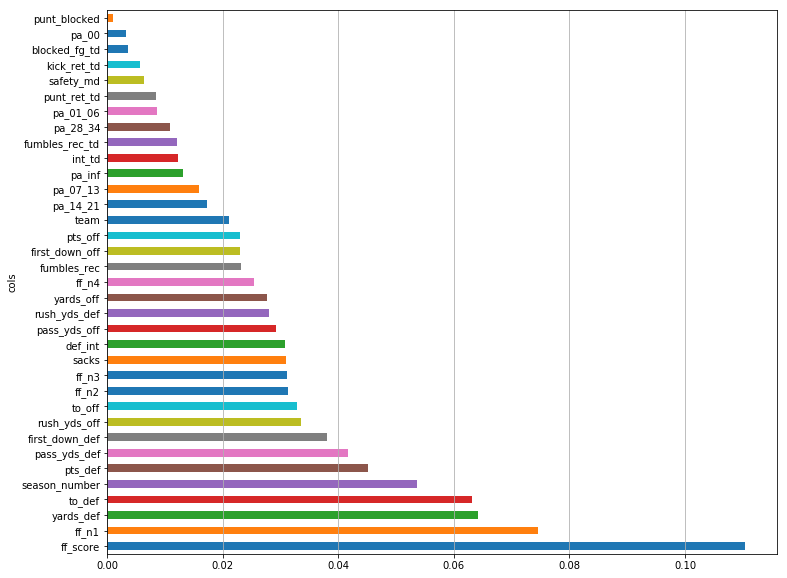

In [366]:
ax = fi.plot('cols', 'imp', 'barh', figsize=(12,10), legend=False, grid=True);
ax.yaxis.grid(False)

In [367]:
top_ft = fi[fi.imp>0.005].cols;
df_x_trn_top_ft = df_x_trn[top_ft]
df_x_val_top_ft = df_x_val[top_ft]

In [368]:
m = RandomForestRegressor(n_estimators=60, max_features=0.5, n_jobs=-1, oob_score=True, random_state=42)
m.fit(df_x_trn_top_ft, df_y_trn)
print_custom_RFscore(df_x_trn_top_ft, df_y_trn, df_x_val_top_ft, df_y_val)

Training rmse: 0.8556186608129869
Validation rmse: 2.2238405304914
Training Score: 0.8896801566044872
Validation Score: 0.21917271021770868
OOB Score: 0.22314111537527015


In [234]:
m = RandomForestRegressor(n_estimators=60, max_features=0.5, n_jobs=-1, oob_score=True, random_state=42)
m.fit(df_x_trn_top_ft, df_y_trn)
print_custom_RFscore(df_x_trn_top_ft, df_y_trn, df_x_val_top_ft, df_y_val)

Training rmse: 0.3055140768541112
Validation rmse: 0.8586156869931426
Training Score: 0.9854186509666959
Validation Score: 0.8966691318546979
OOB Score: 0.896271956678233


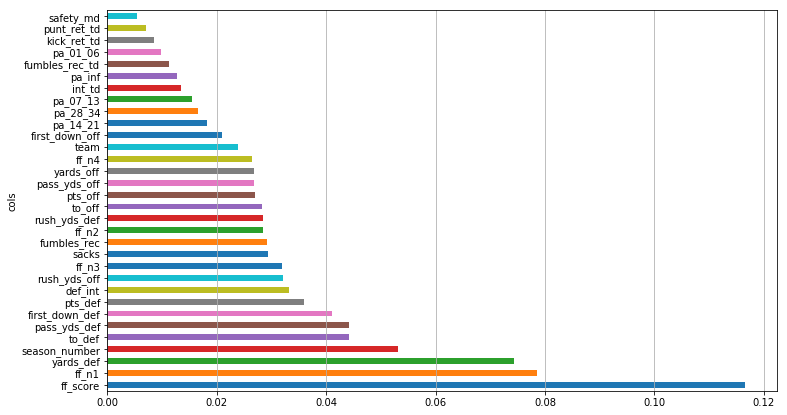

In [369]:
fi = rf_feat_importance(m, df_x_trn_top_ft)
ax = fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False, grid=True);
ax.yaxis.grid(False)

## Predictions

In [370]:
top_ft

29          ff_score
31             ff_n1
21         yards_def
19            to_def
30     season_number
11           pts_def
9       pass_yds_def
3     first_down_def
16      rush_yds_off
20            to_off
32             ff_n2
33             ff_n3
17             sacks
2            def_int
10      pass_yds_off
15      rush_yds_def
22         yards_off
34             ff_n4
5        fumbles_rec
4     first_down_off
12           pts_off
0               team
26          pa_14_21
25          pa_07_13
28            pa_inf
7             int_td
6     fumbles_rec_td
27          pa_28_34
24          pa_01_06
14       punt_ret_td
18         safety_md
8        kick_ret_td
Name: cols, dtype: object

In [373]:
df_teams_predict.head()

,team,Year,blocked_fg_td,def_int,first_down_def,first_down_off,fumbles_rec,fumbles_rec_td,int_td,kick_ret_td,pass_yds_def,pass_yds_off,pts_def,pts_off,punt_blocked,punt_ret_td,rush_yds_def,rush_yds_off,sacks,safety_md,to_def,to_off,yards_def,yards_off,pa_00,pa_01_06,pa_07_13,pa_14_21,pa_28_34,pa_inf,ff_score,season_number,ff_n1,ff_n2,ff_n3,ff_n4,future_score
0,Arizona Cardinals,1994,0.0000,1.4375,15.3125,17.9375,1.6875,0.0000,0.0625,0.0,189.8750,190.4375,16.6875,14.6875,0.0,0.0,85.6250,97.5000,2.1875,0.0625,2.2500,1.8125,275.5000,287.9375,0.0,0.0625,0.3125,0.4375,0.1250,0.0625,10.6875,0,-999.0000,-999.0000,-999.0000,-999.0000,11.3125
1,Arizona Cardinals,1995,0.0625,1.1875,19.3750,17.8125,2.6250,0.0625,0.2500,0.0,215.9375,218.9375,26.3750,17.1875,0.0,0.0,140.5625,85.1875,1.9375,0.0000,2.6250,2.6875,356.5000,304.1250,0.0,0.0000,0.0625,0.2500,0.2500,0.1875,11.3125,1,10.6875,-999.0000,-999.0000,-999.0000,6.8750
2,Arizona Cardinals,1996,0.0000,0.6875,21.0625,19.2500,1.5625,0.0625,0.0625,0.0,218.6875,230.5000,24.8125,18.7500,0.0,0.0,116.3750,93.8750,1.7500,0.0000,1.5625,2.1875,335.0625,324.3750,0.0,0.0000,0.1250,0.2500,0.3750,0.1250,6.8750,2,11.3125,10.6875,-999.0000,-999.0000,7.3125
3,Arizona Cardinals,1997,0.0625,0.9375,18.6250,18.4375,0.7500,0.0000,0.1875,0.0,202.8750,216.1250,23.6875,17.6875,0.0,0.0,136.2500,78.4375,2.1250,0.0000,1.2500,2.6250,339.1250,294.5625,0.0,0.0000,0.1250,0.3125,0.0000,0.1250,7.3125,3,6.8750,11.3125,10.6875,-999.0000,9.5625
4,Arizona Cardinals,1998,0.0000,1.2500,20.0625,19.6875,2.0000,0.0000,0.0625,0.0,204.7500,217.6250,23.6250,20.3125,0.0,0.0,124.3125,101.6875,2.4375,0.0000,2.4375,2.2500,329.0625,319.3125,0.0,0.0625,0.1250,0.2500,0.1875,0.1875,9.5625,4,7.3125,6.8750,11.3125,10.6875,9.0625


In [377]:
df_x_tst = df_teams_avg.copy()
train_cats(df_x_tst)
df_x_tst, df_y, nas = proc_df(df_x_tst, 'future_score')
df_x_tst = df_x_tst.loc[df_x_tst.Year==2017,:]
# top_ft_pos = list(top_ft)
df_x_tst = df_x_tst[top_ft]

In [378]:
df_x_tst.head()

,ff_score,ff_n1,yards_def,to_def,season_number,pts_def,pass_yds_def,first_down_def,rush_yds_off,to_off,ff_n2,ff_n3,sacks,def_int,pass_yds_off,rush_yds_def,yards_off,ff_n4,fumbles_rec,first_down_off,pts_off,team,pa_14_21,pa_07_13,pa_inf,int_td,fumbles_rec_td,pa_28_34,pa_01_06,punt_ret_td,safety_md,kick_ret_td
23,8.0625,10.6250,310.8125,1.3125,23,22.5625,221.3125,17.6875,86.6250,1.5625,11.4375,10.0000,2.3125,0.9375,227.5000,89.5000,314.1250,11.6250,1.1250,19.3750,18.4375,1,0.125,0.1875,0.0625,0.0625,0.0625,0.3750,0.0000,0.0000,0.0,0.0000
75,7.8750,7.1875,318.3750,1.0000,51,19.6875,214.3125,20.1875,115.4375,1.1250,7.6250,6.5625,2.4375,0.5000,249.3750,104.0625,364.8125,5.7500,1.1875,20.6250,22.0625,2,0.500,0.1250,0.0000,0.0000,0.1875,0.0625,0.0000,0.0000,0.0,0.0000
115,13.5000,8.7500,325.0625,2.1250,21,18.9375,213.8125,18.5000,116.0000,1.0625,6.0000,10.0000,2.5625,1.3750,189.3750,111.2500,305.3750,8.5000,1.5625,19.4375,24.6875,4,0.250,0.1250,0.1250,0.1875,0.1875,0.0625,0.0000,0.0625,0.0,0.0625
164,7.7500,7.6875,355.1250,1.5625,47,22.4375,230.5000,21.7500,126.0625,1.0000,7.8750,11.1875,1.6875,1.1250,176.5625,124.6250,302.6250,10.6875,1.0625,17.3750,18.8750,6,0.375,0.2500,0.1875,0.0625,0.1250,0.0625,0.0000,0.0000,0.0,0.0000
187,9.8125,7.6250,317.1250,1.3125,22,20.4375,229.0625,17.6250,131.3750,1.3750,11.0000,9.1250,3.1250,0.6250,192.3125,88.0625,323.6875,12.4375,1.5000,20.0000,22.6875,7,0.250,0.0000,0.0000,0.0000,0.0625,0.2500,0.1875,0.0625,0.0,0.0625


In [379]:
df_teams_avg.loc[df_x_tst.index,'team']

23         Arizona Cardinals
75           Atlanta Falcons
115         Baltimore Ravens
164            Buffalo Bills
187        Carolina Panthers
239            Chicago Bears
287       Cincinnati Bengals
336         Cleveland Browns
388           Dallas Cowboys
436           Denver Broncos
488            Detroit Lions
540        Green Bay Packers
583           Houston Texans
617       Indianapolis Colts
640     Jacksonville Jaguars
688       Kansas City Chiefs
689     Los Angeles Chargers
733         Los Angeles Rams
781           Miami Dolphins
833        Minnesota Vikings
880     New England Patriots
931       New Orleans Saints
983          New York Giants
1031           New York Jets
1066         Oakland Raiders
1118     Philadelphia Eagles
1176     Pittsburgh Steelers
1275     San Francisco 49ers
1317        Seattle Seahawks
1402    Tampa Bay Buccaneers
1423        Tennessee Titans
1475     Washington Redskins
Name: team, dtype: object

In [380]:
df_x_tst_all = df_x_tst.copy()
predict_ff = m.predict(df_x_tst_all)
df_x_tst_all['prediction'] = predict_ff
df_x_tst_all['team'] = df_teams_avg.loc[df_x_tst.index,'team']
df_x_tst_all[['team','prediction']].sort_values('prediction', ascending=False).reset_index(drop=True)

,team,prediction
0,Jacksonville Jaguars,11.094583
1,Arizona Cardinals,10.802199
2,Carolina Panthers,10.378571
3,Seattle Seahawks,9.867708
4,Los Angeles Chargers,9.820536
5,Philadelphia Eagles,9.629216
6,Baltimore Ravens,9.559990
7,Los Angeles Rams,9.194196
8,Chicago Bears,9.115625
9,Tennessee Titans,9.107292
